## Extracción de características
### LBP: Local Binary Patterns

Visión por Computadora 1 - TP4

Para las imágenes suministradas:
1. Implementar un extractor de características LBP básico (sin uniformidad, 8 vecinos)
2. Realizar el histograma de características LBP de la imagen
3. Comparar los histogramas


**LBP: Local Binary Patterns**
1. Invariante frente a cambios monotónicos del nivel de gris (brillo)
2. Invariante a translación
3. 256 patrones

**LBP Uniforme**
* Busca reducir el número de patrones
* U: Medida de uniformidad Nº de transiciones 0 0↔1
* 58+1 patrones

In [1]:
import numpy as np
import cv2 as cv
#from skimage.util import random_noise
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
files = ['cielo.png', 'ladrillos1.png', 'ladrillos2.png', 
         'oveja1.png', 'oveja2.png', 'piedras1.png', 'piedras2.png']

img = cv.imread(files[3])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
medianBl = cv.medianBlur(gray, 5)

((299, 299, 3), (299, 299, 3), (299, 299, 3), (299, 299))

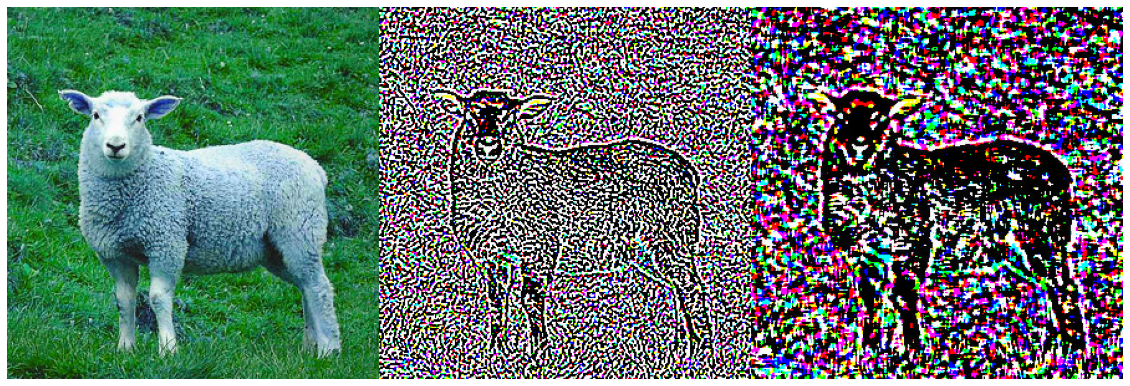

In [3]:
# DoG por sustracción (GaussBlur_low_sigma - GaussBlur_high:sigma)
low_sigma = cv.GaussianBlur(img,(3,3),0,0) # pauto el mismo para ambos ejes: x, y
high_sigma = cv.GaussianBlur(img,(5,5),0,0) # ídem
dog = low_sigma - high_sigma

# aplico nuevo suavizado con filtro de mediana
median = cv.medianBlur(dog,5)
#median2 = cv.medianBlur(img,5)
#mean = cv.blur(img,(5,5))

# concateno imágenes para simplificar dataviz
#out = cv.hconcat([img, low_sigma, high_sigma, dog, median, median2])
out = cv.hconcat([img, dog, median])
plt.figure(figsize=(20,8))
plt.axis('off')
plt.imshow(out);
img.shape, dog.shape, median.shape, gray.shape

Una matriz de 3x3 con el valor de un píxel particular en el centro da lugar a trabajar con 8 vecinos. La cantidad de vecinos se define por el radio (o cantidad de círculos concéntricos llevándolo a espacios matriciales [cuadrados].

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200209171159/threshold1.jpg"/>

Los umbrales (thresholds) varían entre 0 y 1:
* 1: si el valor del píxel vecino es mayor o igual al que estoy analizando
* 0: si el valor del píxel vecino es menor

Con la conversión de la matriz de vecinos en umbrales, "aplasto" los valores binarios de los vecinos (la dimensión 3x3 con excepción del núcleo) en sentido de las agujas del reloj o el contrario (clockwise, anti-clockwise)

Así se obtiene una colección de código **b**inario de 8 díg**it**os (**bit**s) que convertiremos al sistema decimal a partir de la agregación (suma) de valores elevados a una k-potencia secuencial.

Luego reemplazo el valor del píxel central por el valor decimal obtenido... replicando esto para cada píxel de la imagen.

Ver referencias [aquí](https://www.geeksforgeeks.org/create-local-binary-pattern-of-an-image-using-opencv-python/) sobre LBP y [aquí](https://www.electronics-tutorials.ws/binary/bin_2.html) sobre código binario.

In [4]:
# para conversión de los dígitos del sistema binario (en base 2) al decimal (en base 10)
# se omite el valor más significativo dado por el píxel que estoy analizando: 2**8 = 256
power = np.array(range(8))[::-1]
binary2decimal = []

for i in power:
    binary2decimal.append(2**i)
    
binary2decimal = np.array(binary2decimal)
binary2decimal

array([128,  64,  32,  16,   8,   4,   2,   1])

In [5]:
#img_short = gray[:9,:9]
#img_short[2][3] # row, column
#img_short
#np.argsort(np.diag(img_short))

In [6]:
n = len(files)
for i in range(n):
        img = cv.imread(files[i])[:9,:9]
        print(img.shape)
        img_input = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#Todas en BGR

(9, 9, 3)
(9, 9, 3)
(9, 9, 3)
(9, 9, 3)
(9, 9, 3)
(9, 9, 3)
(9, 9, 3)


In [7]:
#defino función para el cálculo de LBP sin uniformidad
def lbp (img):
    # input in gray!
    #img_input = cv.cvtColor(img, cv.COLOR_BGR2GRAY)[:9,:9]
    img_input = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    medianBl = cv.medianBlur(img_input, 5)

    # pierdo 2 píxeles en cada eje (x,y) producto de la búsqueda de vecinos
    # en términos de dimensión de la imagen (matriz) de origen [1 arriba, 1 abajo, 1 izq, 1 der]

    # width, height // row, column 
    x, y = img_input.shape[0], img_input.shape[1] 

    # pensando en bordes cuadrados que comiencen desde esq sup izq
    x_wdw = np.array([-1, -1, -1, 0, 1, 1, 1, 0]).T
    y_wdw = np.array([-1, 0, 1, 1, 1, 0, -1, -1]).T

    # estructura para nueva matriz
    img_lbp = np.zeros((x-2,y-2)) # np.uint8

    # umbrales binarios en vecindad k=8 + conversión a números decimales + new matrix x-2 x y-2
    for i in range(1,x-1):
        for j in range(1,y-1):
            center_value = img_input[i][j]
            list_decimal = []
            for k,l,m in zip(x_wdw, y_wdw, binary2decimal):
                if img_input[i+k][j+l] >= center_value:
                    list_decimal.append(m)
                else:
                    list_decimal.append(0)
            #print(list_decimal)
            img_lbp[i-1][j-1] = sum(list_decimal)

    return img_input, medianBl, img_lbp

# lbp ya queda convertida a números decimales

In [8]:
list_img = []
list_inputs = []
list_medianBlur = []
list_lbp = []

for i in range(n):
    img = cv.imread(files[i])
    list_img.append(img)
    img_input, medianBl, img_lbp = lbp(img)
    list_inputs.append(img_input)
    list_medianBlur.append(medianBl)
    list_lbp.append(np.uint8(img_lbp*255)) # incluyo conversión a 8bits p/plotear y comparar

In [ ]:
#print(len(list_img), len(list_inputs), len(list_hists), len(list_lbp), len(list_hists_lbp))

In [9]:
list_inputs[0].dtype, list_medianBlur[0].dtype, list_lbp[0].dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'))

In [12]:
list_Hgray = []
list_Hlbp = []

for i,j in zip(list_inputs, list_lbp):
    h1 = cv.calcHist(i, [0], None, [256], [0, 256])
    list_Hgray.append(h1)
    h2 = cv.calcHist(j, [0], None, [256], [0, 256])
    list_Hlbp.append(h2)

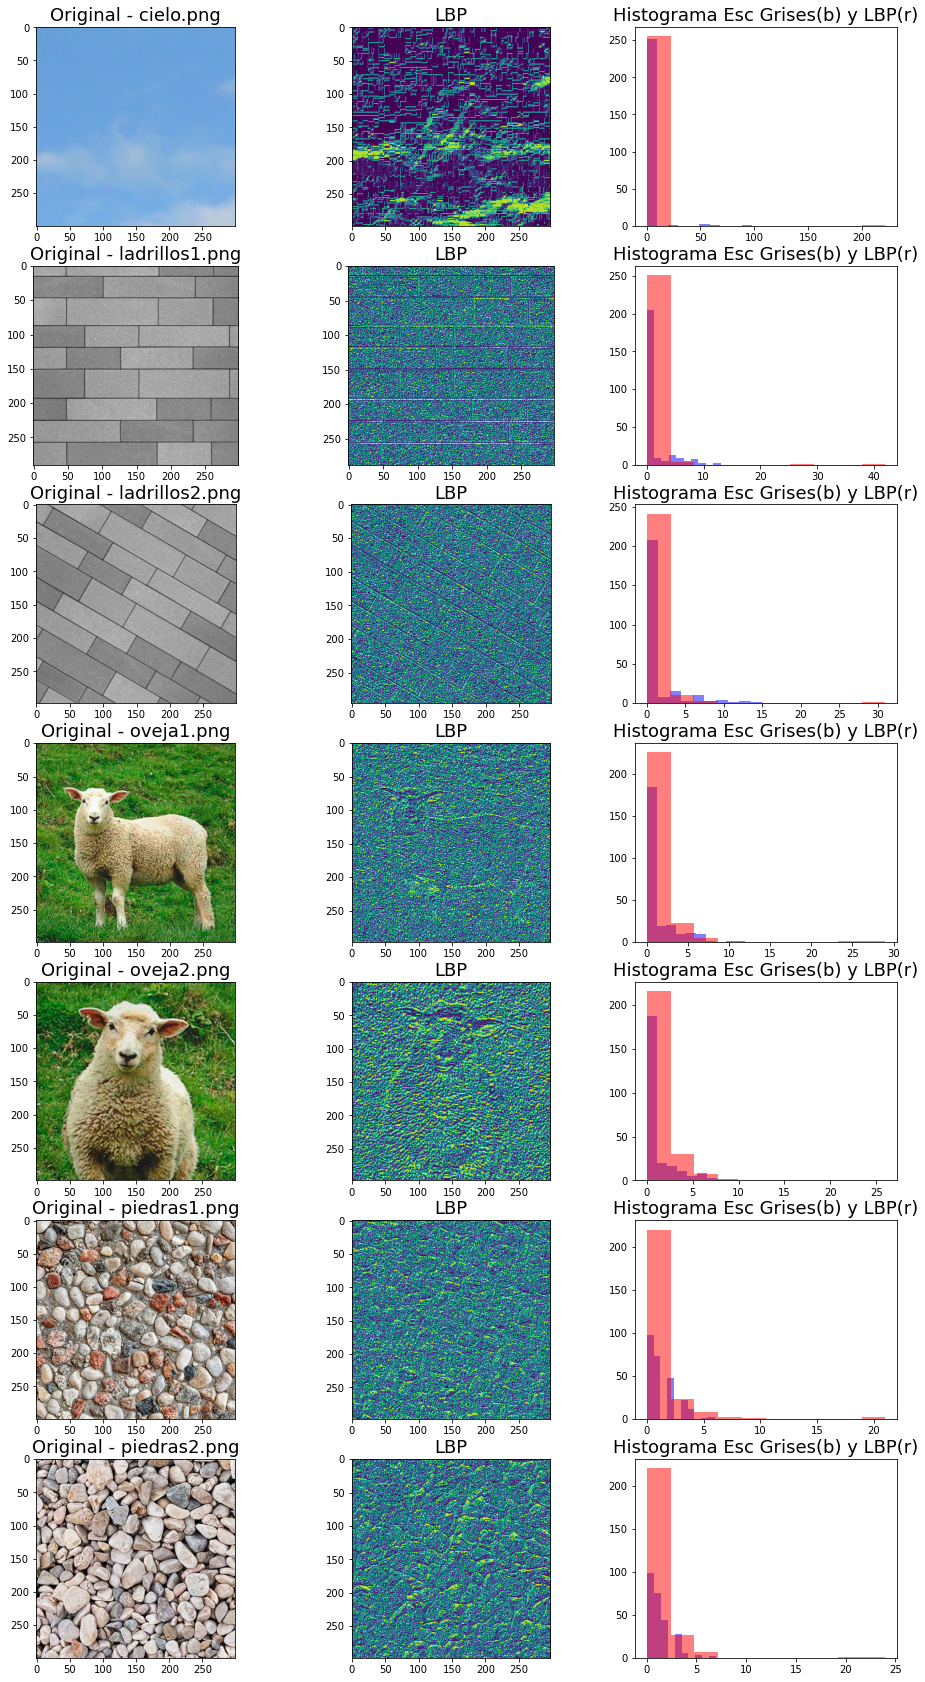

In [20]:
# comparamos histogramas en grises sobre imagen original y la convertida vía LBP
n = len(files)
#n = 4

fig, ax = plt.subplots(n, 3, figsize=(16,30))

for a,i,j,k,l,m in zip(range(n), files, list_img, list_lbp, list_Hgray, list_Hlbp):
    ax[a][0].plot()
    ax[a][1].plot()
    ax[a][2].plot()    
    
    ax[a][0].imshow(j[:,:,::-1]) # rgb
    ax[a][1].imshow(k) #, cmap='gray')
    ax[a][2].hist(l, color='b', alpha=0.5)
    ax[a][2].hist(m, color='r', alpha=0.5)
    
    ax[a][0].set_title('Original - ' + i, fontsize=18)
    ax[a][1].set_title('LBP', fontsize=18)
    ax[a][2].set_title('Histograma Esc Grises(b) y LBP(r)', fontsize=18)

plt.show();

In [21]:
# para ver alternativas
flags = [i for i in dir(cv) if i.startswith('HIST')]
print(flags) 

['HISTCMP_BHATTACHARYYA', 'HISTCMP_CHISQR', 'HISTCMP_CHISQR_ALT', 'HISTCMP_CORREL', 'HISTCMP_HELLINGER', 'HISTCMP_INTERSECT', 'HISTCMP_KL_DIV']


Ver detalles sobre histogramas, [aquí]('https://docs.opencv.org/3.4/d8/dc8/tutorial_histogram_comparison.html0').

Se opta por los métodos HISTCMP_CORREL e HISTCMP_INTERSECT, dada su fácil interpretabilidad: a mayor valor del indicador, mayor es su presición... o similitud.

In [25]:
# comparación sobre transformaciones de la propia imagen
list_correl = []
list_intersect = []

for i, j, k in zip(files, list_Hgray, list_Hlbp):
    correl = cv.compareHist(j,k, cv.HISTCMP_CORREL)
    list_correl.append(correl)
    intersect = cv.compareHist(j,k, cv.HISTCMP_INTERSECT)
    list_intersect.append(intersect)
    print(i, '// h1: gray - h2: lbp \n - Comparación vía correlación:', correl, 
          '\n - Comparación vía intersección:', intersect, '\n')

cielo.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.011162575474223814 
 - Comparación vía intersección: 0.0 

ladrillos1.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.034616328283556826 
 - Comparación vía intersección: 53.0 

ladrillos2.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.06829629831108137 
 - Comparación vía intersección: 42.0 

oveja1.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.1309255715906206 
 - Comparación vía intersección: 50.0 

oveja2.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.15279922247214742 
 - Comparación vía intersección: 50.0 

piedras1.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.1301495886191731 
 - Comparación vía intersección: 95.0 

piedras2.png // h1: gray - h2: lbp 
 - Comparación vía correlación: -0.048423479744970487 
 - Comparación vía intersección: 87.0 



In [26]:
# comparación entre transformaciones de imágenes similares
mask1 = [1, 3, 5] #1st similar
mask2 = [2, 4, 6] #2nd similar

for i,j in zip(mask1, mask2):
    correl = cv.compareHist(list_Hlbp[i], list_Hlbp[j], cv.HISTCMP_CORREL)
    intersect = cv.compareHist(list_Hlbp[i], list_Hlbp[j], cv.HISTCMP_INTERSECT )
    print('LBP// h1:', files[i], ' - h2:', files[j], 
          '\n - Comparación vía correlación:', correl, 
          '\n - Comparación vía intersección:', intersect, '\n')

LBP// h1: ladrillos1.png  - h2: ladrillos2.png 
 - Comparación vía correlación: 0.8900891153933596 
 - Comparación vía intersección: 175.0 

LBP// h1: oveja1.png  - h2: oveja2.png 
 - Comparación vía correlación: 0.7923443861233368 
 - Comparación vía intersección: 162.0 

LBP// h1: piedras1.png  - h2: piedras2.png 
 - Comparación vía correlación: 0.7804478302672386 
 - Comparación vía intersección: 172.0 

